# EAE 127 Project 7: Numerical Nonlinear Lifting-Line Method for Finite Wings


Chung Yin Leung (998238900)

---

Imports and setup code:

In [4]:
import numpy as np
import matplotlib.pyplot as pl
from time import sleep
%matplotlib inline

---

## Introduction

In this project, the Nonlinear Numeric Lifting Line method is implemented and used to determine the aerodynamic properties of finite wings. This method is a numeric implementation that finds a solution to the fundamental equation of Prandtl's lifting- line theory when the 2D lift coefficient does not vary linearly with the angle of attack. By doing this, finite wing performance beyond stall can be examined and included in the overall results. For the entire project, the airfoil used is the NACA 1412 airfoil, but three different chord distributions of the wing will be used.

---

### Problem 1: Nonlinear Numeric Lifting Line Method

#### Approach

A Class is built to contain all the information and results that the nonlinear numeric lifting line method needs and generates. The Class is initialized using geometric properties of the wing, freestream properties, and the $\Gamma_0$ used for the initial elliptical circulation distribution. A function is then defined to implement the lifting line method by accepting an object of the Class and using the properties defined in that object's Class.

The steps to the lifting line method requires the wing geometry to first be discretized. Then a circulation distribution is assumed allowing the first iteration of the induced angle of attack is calculated using Prandtl's Lifting Line Theory. An effective angle of attack can then be calculated through a geometric relationship. Using the effective angle of attack and lift coefficient data for the NACA 1412 airfoil, a lift coefficient can be obtained at all of the discretized spanwise locations. A new circulation distribution can then be calculated using the Kutta-Joukowski Theorem. The new circulation is damped through Successive Under Relaxation, which applies a multiplication factor to the correction, the difference between the new circulation and the old circulation. The correction is then added onto the old circulation to form the actual new circulation. This is repeated until the residual is below a tolerance value. The residual is defined as the maximum absolute value of the difference of the new circulation, before applying the correction factor, and the old circulation.

The lift coefficient data is obtained through XFOIL at a Reynolds number of $10^5$.

#### Equations

The lifting line method relies on Prandtl's Lifting Line Theory. This theory relates the geometry angle of attack with the effective angle of attack and the induced angle of attack under one variable. The result for the induced angle of attack is shown below:

$$
\alpha_i (y_n) = \frac{1}{4\pi V_\infty} \int_\frac{-b}{2}^\frac{b}{2} \frac{\frac{d\Gamma}{dy}}{y_n - y} \rm dy
$$

Because the formula for induced angle of attack will produce a singularity in the integral, a dummy variable of integration is used instead. The dummy variable $\xi$ is related to a discretized $y_i$ with the following equation:

$$
\xi_i = y_i + \frac{dy}{2}
$$

where $dy$ will be constant and is just $y_{i+1}$ - $y_i$.

Substituting the dummy variable forms the following equation for the induced angle of attack:

$$
\alpha_i (y_n) = \frac{1}{4\pi V_\infty} \int_\frac{-b}{2}^\frac{b}{2} \frac{\frac{d\Gamma}{d\xi}}{y_n - \xi} \rm d\xi
$$

The derivative of the circulation with respect to $\xi$ can be defined as a central difference of the circulation in $y$:

$$
\frac{d\Gamma}{d\xi} = \frac{\Gamma(y_{j+1}) - \Gamma(y_{j})}{\Delta \xi}
$$

where $\Delta \xi$ would just be $dy$ if the spacings are constant.

The effective angle of attack can then be calculated from the geometric angle of attack, the induced angle of attack, and geometric twist.

$$
\alpha_{eff} (y)= \alpha_{geom} - \alpha_i (y) - t(y)
$$

And after obtaining the lift coefficients, the Kutta-Joukowski Theorem can calculate a new $\Gamma$ distribution.

$$
\Gamma_{new} = \frac{1}{2} V_\infty c(y) C_l (y)
$$

The residual is then evaluated as follows:

$$
Res = max(abs(\Gamma_{new} - \Gamma_{old}))
$$

And the SUR factor is applied as follows:

$$
\Gamma_{new} = \Gamma_{old} + D(\Gamma_{new} - \Gamma_{old})
$$

where $D$ is the under-relaxation factor.

The initial circulation used is the elliptic circulation distribution. It is defined by the following equation:

$$
\Gamma_{elliptic}(y) = \Gamma_0 \sqrt{1-\left(\frac{2y}{b}\right)^2}
$$

I chose $\Gamma_0$ to be $1$.

#### Code and Results

Class containing information used in the lifting-line method for a wing:

In [5]:
class Wing_NNLL:
    def __init__(self, S, b, chord, geo_twist, circ_0, Cl_data_file, alpha_inf, Vinf = 1, rho_inf=1):
        """Contains information used in the lifting-line method
        ny -- Number of points to discretize wing
        S -- Planform area
        b -- Wing span length
        chord -- A function or constant for the chord values of airfoils along span
        geo_twist -- Geometric angle of attack in degrees (Can be a function or constant)
        circ_0 -- Initial Gamma_0 for an elliptical lift distribution
        Cl_data_file -- String containing location of lift coefficient data file
        alpha_inf -- Freestream angle of attack in degrees
        Vinf -- freestream velocity (default = 1)
        rho_inf -- freestream density
        """
        #Stores geometric properties
        self.plan_area = S
        self.span_len = b
        
        #Initialization parameters that may be a function or constant
        #Chord
        self.chord_init = []
        self.chord_init.append(chord)
        #Geometric angle of attack
        self.geo_twist_init = []
        self.geo_twist_init.append(geo_twist)
        #Gamma_0 for circulation
        self.circ_init = circ_0
        
        #Note 3 lines are skipped when reading
        self.alpha_dat, self.Cl_dat = np.genfromtxt(Cl_data_file,skip_header=3,unpack=True)
        
        #Freestream properties
        self.alpha_inf = alpha_inf
        self.Vinf = Vinf
        self.rho = rho_inf

    def init_alpha_geo(self,ny):
        self.alpha_geo = self.alpha_inf*np.ones((ny,),dtype=float)
    
    def init_geo_twist(self,ny):
        #Initializes geometric angle of attack
        if hasattr(self.geo_twist_init[0], '__call__'):
            self.geo_twist = self.geo_twist_init[0](self.y)
        elif len(self.geo_twist_init) == 1:
            self.geo_twist = self.geo_twist_init*np.ones((ny,),dtype=float)
        else:
            print('Geometric angle of attack must be constant or a function of span')
        
    def init_chord(self,ny):
        #Initializes chord lengths
        if hasattr(self.chord_init[0], '__call__'):
            self.chord = self.chord_init[0](self.y)
        elif len(self.chord_init) == 1:
            self.chord = self.chord_init*np.ones((ny,),dtype=float)
        else:
            print('Chord must be constant or a function of span')

            
    def init_circ(self, ny):
        #Initialize circulation across wing with elliptical distribution
        self.circ = self.circ_init*(1-(2*self.y/self.span_len)**2)**(0.5)
        
        if len(self.circ) != ny:
            print('init_circ mismatch of dimensions!')

            
    def discretize_wing(self, ny):
        #Function discretize wing span into ny points
        if ny < 2:
            print('Must have more than 1 point!')
            return
        #Obtains wing span length
        b = self.span_len
        
        self.ny = ny #Stores ny
        #Initializes y values, and dy
        self.y, self.dy = np.linspace(-b/2, b/2, ny, retstep=True)
        
        #Evaluates for xi (dummy variable)
        self.xi = np.empty((ny-1,),dtype=float)
        for i in range(0,ny-1):
            self.xi[i] = self.y[i] + self.dy/2
        self.dxi = self.xi[1] - self.xi[0]
        
        #Initializes geometry angle of attack
        self.init_alpha_geo(ny)
        #Initializes twist if any
        self.init_geo_twist(ny)
        #Initializes chord
        self.init_chord(ny)
        #Initializes circulation
        self.init_circ(ny)
    
    
    def set_alpha_eff(self, al_eff):
        #Sets effective alpha distribution corresponding to y's
        if len(al_eff) != len(self.y):
            print('Effective alpha distribution must have same number of points as y!')
            return
        self.alpha_eff = al_eff
    
    
    def set_alpha_ind(self, al_ind):
        #Sets induced alpha distribution corresponding to y's
        if len(al_ind) != len(self.y):
            print('Induced alpha distribution must have same number of points as y!')
            return
        self.alpha_ind = al_ind
        
        
    def get_Cl(self, alpha):
        #Retrieves lift coefficient data from an angle of attack
        if (alpha > self.alpha_dat[-1]).any() | (alpha < self.alpha_dat[0]).any():
            print('Required alphas is out of range of Cl data!')
            return
        return np.interp(alpha, self.alpha_dat, self.Cl_dat)
    
    
    def set_circ(self, circ):
        #Sets circulation distribution corresponding to y's
        if len(circ) != len(self.y):
            print('Circulation distribution must have same number of points as y!')
            return
        self.circ = circ
    
    
    def plot_circ(self, title, label, normalized = 0):
        #Plots the circulation
        #Retrieves properties
        Gamma_0 = max(self.circ)
        Gamma = self.circ
        y = self.y
        b = self.span_len
        
        if normalized != 0:
            y = y/(b/2)
            Gamma = Gamma/Gamma_0
            
        if normalized != 0:
            pl.plot([y[i] for i in range(0,self.ny) if y[i] >= 0], [Gamma[i] for i in range(0,self.ny) if y[i] >= 0]
                                   ,label = label)
            pl.ylabel('$\\frac{\Gamma}{\Gamma_0}$', fontsize = 25)
            pl.xlabel('$\\frac{2y}{b}$', fontsize = 25)
        else:
            pl.plot(y, Gamma, label = label)
            pl.ylabel('$\Gamma$', fontsize = 25)
            pl.xlabel('$y$', fontsize = 25)
            
        pl.title(title, fontsize = 16)
        ymin, ymax = pl.ylim()
        pl.ylim((ymin+0.1*ymin,ymax+0.1*ymax))
        xmin, xmax = pl.xlim()
        pl.xlim((xmin+0.1*xmin,xmax+0.1*xmax))
    
    def plot_alpha_eff(self, title, label):
        pl.plot(self.y[1:-1], self.alpha_eff[1:-1], label = label)
        pl.ylabel('$\\alpha_{eff}$', fontsize = 25)
        pl.xlabel('$y$', fontsize = 25)
        pl.title(title, fontsize = 16)

    def reinitialize(self):
        self.discretize_wing(self.ny)

Function that iterates for the circulation and effective angle of attack distribution:

In [6]:
def Lifting_Line_Method(wing, D, tol):
    """Implementation of the lifting-line method
    wing -- an object of the Wing_NNLL class
    D -- Correction factor
    tol -- Tolerance for residual to stop iteration
    """
    def alpha_eff(wing):
        #Function solves for effective alpha distribution
        #Retrieves number of y points
        ny = wing.ny
        y = wing.y
        Gamma = wing.circ
        xi = wing.xi
        dxi = wing.dxi
        
        #Evaluates for the derivative of Gamma
        dGamma_dxi = np.empty((ny-1,),dtype=float)
        for j in range(0, ny - 1):
            dGamma_dxi[j] = (Gamma[j+1] - Gamma[j])/dxi
        
        #Evaluates for alpha induced
        al_i = np.empty((ny,),dtype=float)
        for n in range(0, ny):
            #Initializes integrand array to store values in integral
            integrand = np.empty((ny-1,),dtype=float)
            for j in range(0, ny - 1):
                integrand[j] = dGamma_dxi[j]/(y[n] - xi[j])
            
            al_i[n] = np.trapz(integrand,xi)/(4*np.pi*wing.Vinf)
            
        
        #Calculates alpha effective
        al_eff = wing.alpha_geo - al_i - wing.geo_twist
        #Sets alpha effective & alpha induced
        wing.set_alpha_eff(al_eff)
        wing.set_alpha_ind(al_i)
        
        return alpha_eff
    
    def Circulation_new(wing):
        #Function solves for new circulation
        
        #Obtains lift coefficient values
        Cl_y = wing.get_Cl(wing.alpha_eff)

        #Calculates new circulation
        circ_new = [0.5*wing.Vinf*wing.chord[i]*Cl_y[i] for i in range(0,wing.ny)]
        #Set tip vortices to 0 as BC
        circ_new[0] = 0; circ_new[-1] = 0;
        #Calculates residual
        res = max(abs(circ_new - wing.circ))
        #Applies correction factor
        circ_new = wing.circ + D*(circ_new - wing.circ)
        #Sets new circulation
        wing.set_circ(circ_new)
        
        return circ_new, res
    
    
    #Initializes residual
    res = 1.
    #Initializes variable to store # of iterations
    iterations = 0
    while (res > tol):
        alpha_eff(wing)
        circ_new, res = Circulation_new(wing)
        iterations += 1
        if iterations == 5001:
            print('Iterations exceeded 5000:')
        
        if iterations == 10001:
            print('Iterations exceeded 10000:')
        
        if iterations == 15001:
            print('Iterations exceeded 15000:')

    
    return iterations, wing

Main script:

In [7]:
#Wing geometric parameters
AR = 20.
b = 1.
S = (b**2)/AR
c = S/b
geo_twist = 0.
#Initial Gamma_0
Gamma_0 = 1.
#Freestream properties
alpha_inf = 0.
Vinf = 1.
rho_inf = 1.

#Initializes Wing for Numerical Nonlinear Lifting Line Method
NACA1412 = Wing_NNLL(S, b, c, geo_twist, Gamma_0, 'NACA1412.dat', alpha_inf, Vinf, rho_inf)
NACA1412.discretize_wing(301)

In [8]:
#Parameters for iteration
D = 0.05
tol = 1.e-3

iterations, abc = Lifting_Line_Method(NACA1412, D, tol)

#Anderson results
y_norm = [0, 0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
Gamma_norm = [1, 0.995, 0.99, 0.975, 0.965, 0.95, 0.93, 0.9, 0.8, 0.63]

Code for plots:

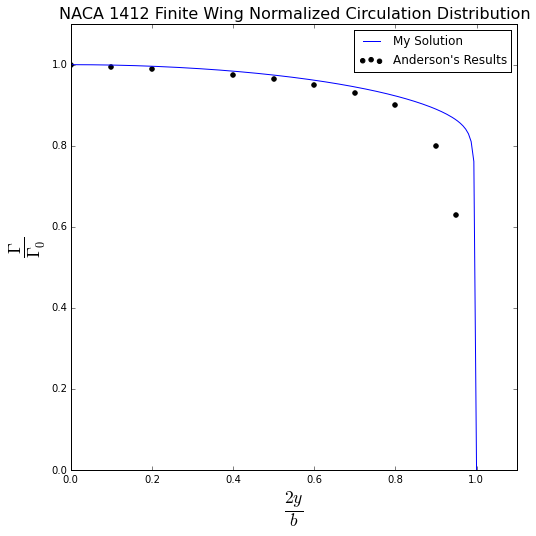

In [9]:
pl.figure(figsize = (8,8))
NACA1412.plot_circ('NACA 1412 Finite Wing Normalized Circulation Distribution', 'My Solution', 1)
pl.scatter(y_norm, Gamma_norm, label = 'Anderson\'s Results', color = 'k');
pl.legend(loc = 'best');


**Figure 1: NACA 1412 Finite Wing Normalized Circulation Distribution**

My solution is fairly consistent with Anderson's results for about half of the half-span. My solution began to deviate from Anderson's results when the circulation distribution approaches the tip, where it must be 0 to be physically realistic. The difference in the results can be attributed to the damping factor on the correction, and the tolerance value at which the iteration is stopped. For lower tolerances, the right "corner" of the circulation distribution is smoother. For higher tolerances, the corner is much sharper. Different damping factors can also cause a different solution to be converged.

---

### Problem 2: Lift Distribution of Various Wings With NACA 1412 Airfoil Sections

#### Approach

The Lifting Line implementation from Problem 1 is reused with a different set of wing geometric parameters and freestream parameters. Three wings with the NACA 1412 airfoil are examined. The lift coefficient data are obtained at the Reynolds number calculated from the given conditions. The only difference between the three wings is the chord distribution. For the elliptic and tapered wing, a function is found for the chord along the span. The elliptic wing is modeled using a symmetric elliptic chord distribution. The tapered wing's chord is a piecewise function where the chord changes direction at the root. Initializing each wing with the different chords using the Class defined in Problem 1 allows the Lifting Line method to be implemented in the same way as in Problem 1. The Lifting Line method allows the circulation distribution and effective angle of attack distribution to be found and plotted. Through those two distributions, the lift coefficient and the induced drag coefficient are also found.

#### Equations

The Reynolds number for the given conditions is calculated using the following equation:

$$
Re_{c_r} = \frac{\rho_\infty V_\infty c_r}{\mu_\infty}
$$

For an elliptic wing, the chord is a function of the span:

$$
c_{elliptic}(y) = c_0 \sqrt{1-\left(\frac{2y}{b}\right)^2}
$$

where

$$
c_0 = \frac{S}{\int_{-b/2}^{b/2}\sqrt{1-\left(\frac{2y}{b}\right)^2} \rm dy} = \frac{4S}{b\pi}
$$


For a rectangular wing, the chord is constant:

$$
c_{rect} = \frac{S}{b}
$$

For a tapered wing, the chord is a linear function of the span, but split into two parts:

$$
c_1(y) = \frac{2}{b} (c_r - c_t)y + c_r,\ \ \rm for \ \ \frac{-b}{2} \le y \le 0
$$

and

$$
c_2(y) = \frac{-2}{b} (c_r - c_t)y + c_r,\ \ \rm for \ \ 0 \le y \le \frac{b}{2}
$$

where

$$
c_t = \frac{2S}{b} - c_r
$$

The lift coefficient can be calculated using Eq. 5.26 from Anderson's:

$$
C_L = \frac{2}{V_\infty S} \int_{-b/2}^{b/2} \Gamma (y) \rm dy
$$

And the induced drag coefficient can be calculated using Eq. 5.30 from Anderson's:  

$$
C_{D,i} = \frac{2}{V_\infty S} \int_{-b/2}^{b/2} \Gamma (y) \alpha_i (y) \rm dy
$$

Both are implemented in the function below:

In [10]:
def calc_CL_CDi(wing):
    Gamma = wing.circ
    alpha_ind = wing.alpha_ind
    y = wing.y
    
    CL = 2*np.trapz(Gamma,y)/(wing.Vinf*wing.plan_area)
    CDi = 2*np.trapz(Gamma*alpha_ind,y)/(wing.Vinf*wing.plan_area)
    
    return CL, CDi

The last equation used is the lift coefficient at cruise:

$$
C_{L,cruise} = \frac{W}{0.5\rho_\infty V_\infty^2 S}
$$

#### Code and Results

Given properties:

In [14]:
#CL Data Input Path
CL_dat_path = 'NACA1412_Prob2.dat'

#Load on wing
Weight = 9200 #lbf

#Wing geometric properties
S = 235 #ft^2
b = 50 #ft
AR = b**2/S
cr = 8.48 #ft Root chord
geo_twist = 0. #From airfoil

#Freestream properties
alpha_inf = 5.
Vinf = 362*5280/(60*60)
rho_inf = 1.1435e-3 #slugs/ft^3
mu = 3.25e-7 #slugs/(ft*s)

#Calculates Reynolds number
Re = rho_inf*Vinf*cr/mu

#Initial Gamma_0
Gamma_0 = 1.

#Parameters for iteration
D = 0.05
tol = 1.e-3


The Reynolds number is $15.841(10^6)$ based on the root chord.

Initializes elliptic wing:

In [15]:
def chord_elliptic(y):
    c_0 = 4*S/(b*np.pi)
    return c_0*(1-(2*y/b)**2)**(0.5)

In [17]:
#Initializes Elliptic Wing
elliptic = Wing_NNLL(S, b, chord_elliptic, geo_twist, Gamma_0, CL_dat_path, alpha_inf, Vinf, rho_inf)
elliptic.discretize_wing(301)

Initializes rectangular wing:

In [18]:
c_rec = S/b
#Initializes rectangular Wing
rect = Wing_NNLL(S, b, c_rec, geo_twist, Gamma_0, CL_dat_path, alpha_inf, Vinf, rho_inf)
rect.discretize_wing(301)

Initializes tapered wing:

In [19]:
def chord_tapered(y):
    ct = 2*S/b - cr
    y = np.array(y,dtype=float)
    c = np.empty((len(y),),dtype=float)
    for i in range(0,len(y)):
        if (y[i] >= -b/2) & (y[i] <= 0):
            c[i] = (2/b)*(cr - ct)*y[i] + cr
        elif (y[i] >= 0) & (y[i] <= b/2):
            c[i] = (-2/b)*(cr - ct)*y[i] + cr
        else:
             print('Out of range!')
             return
    return c

In [20]:
#Initializes tapered Wing
tapered = Wing_NNLL(S, b, chord_tapered, geo_twist, Gamma_0, CL_dat_path, alpha_inf, Vinf, rho_inf)
tapered.discretize_wing(301)

Code to plot Planform Geometries:

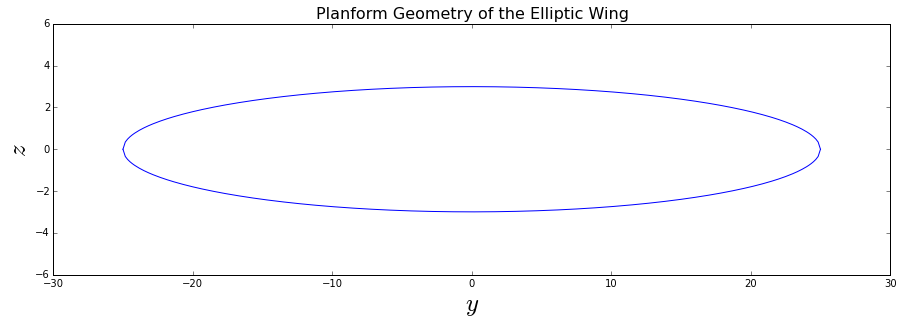

In [21]:
pl.figure(figsize = (15,4.5))

pl.plot(elliptic.y, elliptic.chord/2, elliptic.y, -elliptic.chord/2, color = 'b')
pl.ylim((-6,6));
pl.title('Planform Geometry of the Elliptic Wing', fontsize = 16);
pl.ylabel('$z$', fontsize = 25);
pl.xlabel('$y$', fontsize = 25);

**Figure 2: Planform Geometry of the Elliptic Wing**

Figure 2 shows the top-down view of the elliptic wing.

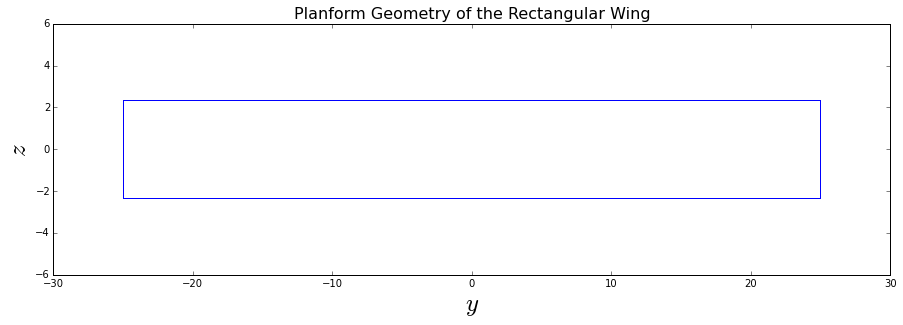

In [22]:
pl.figure(figsize = (15,4.5))

pl.plot(rect.y, rect.chord/2, rect.y, -rect.chord/2, color = 'b');
pl.plot([rect.y[0],rect.y[0]],[rect.chord[0]/2, -rect.chord[0]/2], color = 'b')
pl.plot([rect.y[-1],rect.y[-1]],[rect.chord[-1]/2, -rect.chord[-1]/2], color = 'b')
pl.ylim((-6,6));
pl.title('Planform Geometry of the Rectangular Wing', fontsize = 16);
pl.ylabel('$z$', fontsize = 25);
pl.xlabel('$y$', fontsize = 25);

**Figure 3: Planform Geometry of the Rectangular Wing**

Figure 3 shows the top-down view of the rectangular wing.

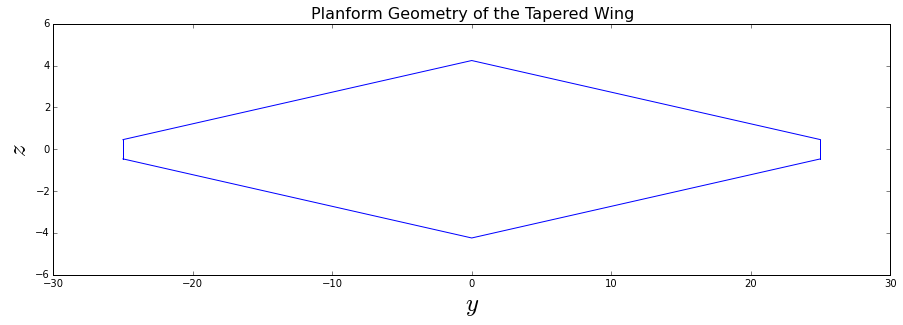

In [23]:
pl.figure(figsize = (15,4.5))

pl.plot(tapered.y, tapered.chord/2, tapered.y, -tapered.chord/2, color = 'b');
pl.plot([tapered.y[0], tapered.y[0]],[tapered.chord[0]/2, -tapered.chord[0]/2], color = 'b')
pl.plot([tapered.y[-1], tapered.y[-1]],[tapered.chord[-1]/2, -tapered.chord[-1]/2], color = 'b')
pl.ylim((-6,6));
pl.title('Planform Geometry of the Tapered Wing', fontsize = 16);
pl.ylabel('$z$', fontsize = 25);
pl.xlabel('$y$', fontsize = 25);

**Figure 4: Planform Geometry of the Tapered Wing**

Figure 4 shows the top-down view of the tapered wing.

Code to calculate circulation and effective angle of attack distributions:

In [24]:
Lifting_Line_Method(elliptic, D, tol);
Lifting_Line_Method(rect, D, tol);
Lifting_Line_Method(tapered, D, tol);

Code to plot circulation and effective angle of attack distributions

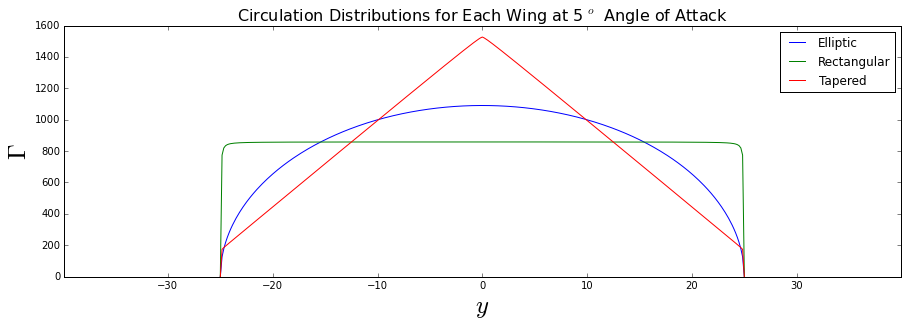

In [25]:
pl.figure(figsize = (15,4.5))
elliptic.plot_circ('Elliptic', 'Elliptic');
rect.plot_circ('Rect', 'Rectangular');
tapered.plot_circ('Circulation Distributions for Each Wing at 5 $^o$ Angle of Attack', 'Tapered');
pl.legend(loc='best');

**Figure 5: Circulation Distributions for Each Wing at 5 $^o$ Angle of Attack**

Figure 5 shows the circulation distributions for each wing. The plots show that the circulation distribution is heavily influenced by the chord distribution. The elliptic wing's circulation ressembles a elliptic wing's chord distribution, the rectangular wing's circulation distribution resembles a rectangular wing, and the tapered wing resembles the chord distribution's piecewise shape. The maximums for the circulation is at different values. The tapered wing has the highest circulation maximum while the rectangular wing has the lowest circulation maximum. And the tapered wing seems to be a "midpoint" wing between the rectangular wing and the elliptic wing. The tapered wing's circulation distribution replaces the sharp "corner" in the rectangular wing's distribution with a slope and has a single maximum circulation value similar to the elliptic wing's distribution.

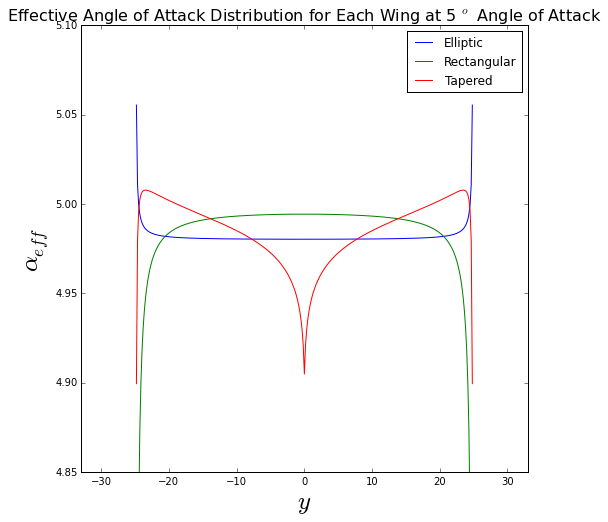

In [28]:
pl.figure(figsize = (8,8))
elliptic.plot_alpha_eff('Elliptic', 'Elliptic')
rect.plot_alpha_eff('Rect', 'Rectangular')
tapered.plot_alpha_eff('Effective Angle of Attack Distribution for Each Wing at 5 $^o$ Angle of Attack', 'Tapered')
pl.legend(loc='best');
pl.ylim((4.85,5.10));
xmin, xmax = pl.xlim()
pl.xlim((xmin+0.1*xmin,xmax+0.1*xmax));

**Figure 6: Effective Angle of Attack Distributions for Each Wing at 5 $^o$ Angle of Attack**

Figure 6 shows the effective angle of attack distributions for each wing. The plot is generated without the effective angles of attack at the tips because those values are exploded but the trends can still be seen in the figure. The elliptic wing and the rectangular wing has a smooth effective angle of attack in the middle of the wing span. But the elliptic wing's effective angle of attack is lower while the rectangular wing's effective angle of attack is higher. At the tips, the elliptic wing's effective angle of attack increases exponentiallly while the rectangular wing's effective angle of attack decreases exponentially. The tapered wing's effective angle of attack is very different from the other two. The tapered wing has a very low effective angle of attack at the root and a decreasing effective angle of attack when moving in from the tips to the root. This would mean that the tapered wing produces more induced drag. At the tips, the tapered wing's effective angle of attack decreases exponentially, similar to the rectangular wing.

In [41]:
#Parameters of alpha sweep
alpha_start = -10
alpha_end = 24
alpha_step = 0.5
#Initializes range of alphas to sweep
alpha_range = np.arange(alpha_start, alpha_end, alpha_step, dtype=float)


#Initializes arrays to store lift coeffs and drag coeffs
CL_elliptic = np.zeros((len(alpha_range),), dtype=float)
CDi_elliptic = np.zeros((len(alpha_range),), dtype=float)

CL_rect = np.zeros((len(alpha_range),), dtype=float)
CDi_rect = np.zeros((len(alpha_range),), dtype=float)

CL_tapered = np.zeros((len(alpha_range),), dtype=float)
CDi_tapered = np.zeros((len(alpha_range),), dtype=float)

In [30]:
#Initializes Elliptic Wing
elliptic = Wing_NNLL(S, b, chord_elliptic, geo_twist, Gamma_0, CL_dat_path, alpha_inf, Vinf, rho_inf)
elliptic.discretize_wing(301)

In [31]:
#Initializes rectangular Wing
rect = Wing_NNLL(S, b, c_rec, geo_twist, Gamma_0, CL_dat_path, alpha_inf, Vinf, rho_inf)
rect.discretize_wing(301)

In [32]:
#Initializes tapered Wing
tapered = Wing_NNLL(S, b, chord_tapered, geo_twist, Gamma_0, CL_dat_path, alpha_inf, Vinf, rho_inf)
tapered.discretize_wing(301)

In [37]:
#Exports the iterated data into a text file

def save_CLCDi_iter(alpha, CL, CDi, filename):
    dat = np.zeros((len(alpha),3), dtype = float)
    for i in range(0,len(alpha)):
        dat[i,0] = alpha[i]
        dat[i,1] = CL[i]
        dat[i,2] = CDi[i]

    np.savetxt(filename, dat, fmt = '% 00f',header='   alpha        Cl        Cd')

In [38]:
for i in range(0,len(alpha_range)):
    #Sets new angle of attack and reinitializes wing
    elliptic.alpha_inf = alpha_range[i]
    elliptic.reinitialize()
    #Finds circulation and effective angle of attack distributions
    Lifting_Line_Method(elliptic, D, tol);
    #Solves for lift coefficient and drag coefficient
    CL_elliptic[i], CDi_elliptic[i] = calc_CL_CDi(elliptic)
    
    #save_CLCDi_iter(alpha_range, CL_elliptic, CDi_elliptic, 'CLCDi_elliptic.dat')


In [39]:
for i in range(0,len(alpha_range)):
    #Sets new angle of attack and reinitializes wing
    rect.alpha_inf = alpha_range[i]
    rect.reinitialize()
    #Finds circulation and effective angle of attack distributions
    Lifting_Line_Method(rect, D, tol);
    #Solves for lift coefficient and drag coefficient
    CL_rect[i], CDi_rect[i] = calc_CL_CDi(rect)
    
    #save_CLCDi_iter(alpha_range, CL_rect, CDi_rect, 'CLCDi_rect.dat')


In [42]:
for i in range(0,len(alpha_range)):
    #Sets new angle of attack and reinitializes wing
    tapered.alpha_inf = alpha_range[i]
    tapered.reinitialize()
    #Finds circulation and effective angle of attack distributions
    Lifting_Line_Method(tapered, D, tol);
    #Solves for lift coefficient and drag coefficient
    CL_tapered[i], CDi_tapered[i] = calc_CL_CDi(tapered)
    
    #save_CLCDi_iter(alpha_range, CL_tapered, CDi_tapered, 'CLCDi_tapered.dat')

In [44]:
#Or load from files

alpha_range, CL_elliptic, CDi_elliptic = np.loadtxt('CLCDi_elliptic.dat',skiprows = 1, unpack = True)

alpha_range, CL_rect, CDi_rect = np.loadtxt('CLCDi_rect.dat',skiprows = 1, unpack = True)

alpha_range, CL_tapered, CDi_tapered = np.loadtxt('CLCDi_tapered.dat',skiprows = 1, unpack = True)

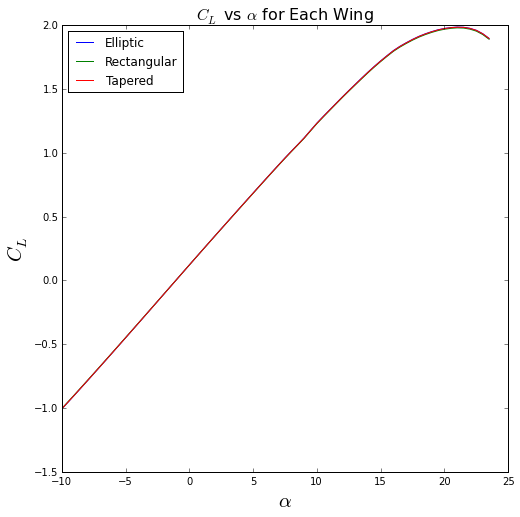

In [45]:
pl.figure(figsize=(8,8))
pl.plot(alpha_range,CL_elliptic,label = 'Elliptic');
pl.plot(alpha_range, CL_rect, label = 'Rectangular');
pl.plot(alpha_range, CL_tapered, label = 'Tapered');
pl.ylabel('$C_L$', fontsize = 20);
pl.xlabel('$\\alpha$', fontsize = 20);
pl.title('$C_L$ vs $\\alpha$ for Each Wing', fontsize = 16);
pl.legend(loc='best');

**Figure 7: Lift Coefficient versus Angle of Attack for Each Wing**

Figure 7 shows the lift curve for each of the wings. Without looking at the values directly, each wing seems to have the same lift curve. From Anderson's analysis of a general lift distribution, Eq. 5.53 from Anderson's shows that the lift coefficient is mainly dependent on the aspect ratio. Because the aspect ratio is the same in all cases the lift curve for each wing is roughly the same.

In [46]:
print('Aspect Ratio (same for each wing):', AR)

Aspect Ratio (same for each wing): 10.638297872340425


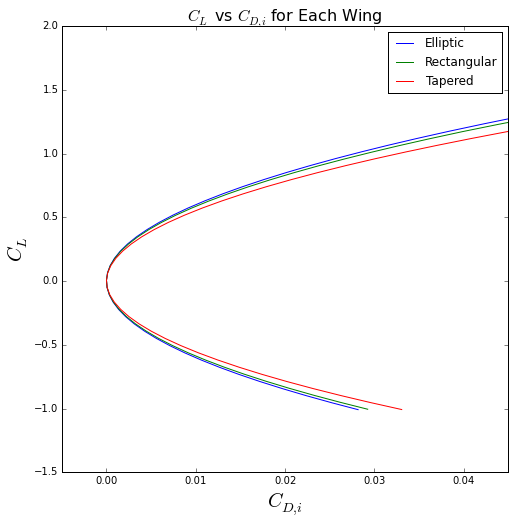

In [47]:
pl.figure(figsize=(8,8))
pl.plot(CDi_elliptic,CL_elliptic,label = 'Elliptic');
pl.plot(CDi_rect, CL_rect, label = 'Rectangular');
pl.plot(CDi_tapered, CL_tapered, label = 'Tapered');
pl.ylabel('$C_L$', fontsize = 20);
pl.xlabel('$C_{D,i}$', fontsize = 20);
pl.title('$C_L$ vs $C_{D,i}$ for Each Wing', fontsize = 16);
pl.legend(loc='best');
pl.xlim((-0.005,0.045));

**Figure 8: Lift Coefficient versus Induced Drag Coefficient for Each Wing**

Figure 8 shows the induced drag polar for each wing. Because each wing's lift curve is the same, the drag polar for each wing has the same bell curvature. The difference is that for there is a different $C_{D,i}$ value for each $C_L$ value. In the plot, this can be seen as horizontal offsets at the beginnings and ends of the curves. From Anderson's analysis on a general lift distribution, Eq. 5.61 and 5.62 shows that the induced drag coefficient will be different for the differently shaped wings due to a span effiency factor. From Figure 5.20 of Anderson's Fundamentals, this tapered wing actually has a low span efficiency factor because of the low taper ratio $(c_t/c_r)$ and high aspect ratio. The tapered wing can be conpared to the rectangular wing. For this tapered wing, the taper ratio is roughly 0 while the rectangular wing's taper ratio is 1. From the figure, at any of the aspect ratio, the span efficiency factor is higher for a taper ratio of 1 than for a taper ratio of 0, matching the results of the plot. In addition, the elliptic wing is furthest to the left because it has the lowest induced drag, matching the results where an elliptic wing has the highest span efficiency factor.

Since the lift coefficients for each of the wings are the same, only the drag has to be compared to determine the wing with the best performance. So because the elliptic wing has the lowest induced drag, it is the best performing wing.

In [48]:
CL_cruise = Weight/(0.5*rho_inf*S*Vinf**2)
alpha_cruise = np.interp(CL_cruise,CL_tapered,alpha_range)

In [50]:
print('Angle of attack at cruise from current results:', alpha_cruise)

Angle of attack at cruise from current results: 1.0647211621658688


My $\alpha_{cruise}$ from Project 5 is 0.5737 degrees, compared to 1.0647 degrees from the Lifting Line method.

The angle of attack at cruise from the lifting line method is lower than the angle of attack at cruise from Project 5. This is expected because the lifting line method incorpates the changes to lift due to downwash into the lift curve. For a higher angle of attack at cruise, the lift curve must have shifted down due to less lift being generated. This effect only exists for a finite wing. In Project 5, an airfoil's lift curve is used, which is only good for approximating an infinite wing. For an infinite wing, there is no downwash to change the lift curve. As a result, Project 5's angle of attack at cruise is less than  the angle of attack obtained by the Lifting Line method.

---

## Conclusion

The results of the lifting-line method matches the general lift distribution analysis done by Anderson in the book. For any wing shape, this method can find the lift curve and induced drag on the wing at any angle of attack only if the lift coefficient data for the airfoil in the wing is available at the angles of attack of interest. Without the airfoil lift coefficient data, this method cannot be implemented. However, for a given wing shape of a certain aspect ratio, this method can be run just once in order to obtain the span efficiency factor. With the span efficiency factor, the induced drag for a given wing shape can be calculated using the lift curve of another wing shape with the same aspect ratio. In addition, the span efficiency factor can be an indicator of the performance of a wing since wings with the same aspect ratio will have the same lift curve. Overall, the nonlinear numerical lifting line method can be a very useful tool.